# Desafío Spike : 'Predicción de caudales extremos'
### Gonzalo Riquelme

1. Baja el archivo caudal_extra.csv. Puedes bajarlo de BigQuery (vean el código al final de este documento), o bien, desde Github (https://github.com/SpikeLab-CL/desafio_spike_cuencas).

In [138]:
%matplotlib inline
import os
os.chdir('C:/Users/iriqu/desktop/Gonzalo/programacion/desafiospike')

In [139]:
import pandas as pd
data = pd.read_csv('caudal_extra.csv',header=0, parse_dates=['fecha'], index_col='fecha')
data = data['1990':]
#Se toman datos desde 1990 para evitar problemas de memoria, 50% aprox.

2. Analiza el dataset caudal_extra.csv. ¿Qué puedes decir de los datos, distribuciones, missing, u otros? ¿Hay algo que te llame la atención? ¿Por qué hay tantos valores missing? Pensar en la manera en que se elaboró el dataset, descrito más arriba. (Entregable: texto/imágenes)

In [141]:
#Primero visualizamos los datos para tener una idea general
data.head(3)

,Unnamed: 0,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
fecha,,,,,,,,,,,,,,,,
1995-08-31,135,10414001,DGA,dga_web,Rio Maullin En Las Quemas,0,-41.400002,-73.216698,104,Rio Maullin,6554,141.0,10414001,Rio Maullin En Las Quemas,4.6,12.200000
1995-12-13,136,10414001,DGA,dga_web,Rio Maullin En Las Quemas,0,-41.400002,-73.216698,104,Rio Maullin,6554,77.8,10414001,Rio Maullin En Las Quemas,0.0,21.500000
1995-12-20,137,10414001,DGA,dga_web,Rio Maullin En Las Quemas,0,-41.400002,-73.216698,104,Rio Maullin,6554,73.9,10414001,Rio Maullin En Las Quemas,0.0,21.700001


In [142]:
# Se identifican valores únicos para algunas variables, de esta forma se pueden ver cantidades involucradas (cuencas, estaciones,etc)

print('Número de años',len(data.index.year.unique()))
print('Número de sub-cuencas',len(data.nombre_sub_cuenca.unique()))
print('Número de cuencas',len(data.codigo_cuenca.unique()))
print('Número de nombres de cuencas',len(data.gauge_name.unique()))
print('Número de id de cuencas',len(data.gauge_id.unique()))
print('Número de nombres',len(data.nombre.unique()))
print('Número de estaciones de medicion de caudal',len(data.codigo_estacion.unique()))
print('Número de fuentes de informacion', len(data.fuente.unique()))
print('Número de instituciones de informacion', len(data.institucion.unique()))


Número de años 29
Número de sub-cuencas 76
Número de cuencas 29
Número de nombres de cuencas 123
Número de id de cuencas 123
Número de nombres 123
Número de estaciones de medicion de caudal 123
Número de fuentes de informacion 1
Número de instituciones de informacion 1


Se puede notar que 'gauge_id','gauge_name','nombre' y 'codigo_estacion', identifican de la misma forma. Cada id de una cuenca está asociada a una estación de medición. Por lo tanto, se eliminan gauge_name y nombre que, además, son lo mismo. Tambien se eliminan 'Unnamed: 0', 'fuente', 'intstitucion','latitud'y 'longitud', no se utilizan por el momento.

In [143]:
data=data.drop(columns=['Unnamed: 0','fuente','institucion','latitud','longitud','gauge_name','nombre'])

In [145]:
# A continuación se revisan missing values

print('Tamaño de la muestra:',len(data))
null=data.isnull().sum()
percent=null*100/len(data)
missingtable=pd.concat([null,percent],axis=1)
missingtable=missingtable.rename(columns={0:'# de observaciones',1:'%',2:'dtype'})
missingtable=missingtable[missingtable['# de observaciones']>0]
print('Tabla missing values')
missingtable.sort_values(by='%',ascending=False)

Tamaño de la muestra: 892222
Tabla missing values


,# de observaciones,%
temp_max_promedio,33662,3.772828
precip_promedio,7799,0.874110


En las instrucciones del desafío se explica que los datos de **caudal** provienen de una fuente distinta a los datos de **temperatura** y **precipitación**. De esta manera, existen cuencas (con el dato **caudal**) que no presentan los datos de **temperatura y precipitación**. 

3. Plots de precipitación, temperatura y caudal

a. Escribir una función que tome como input una estación y haga plot de los datos para
una columna. Debiese tener estos argumentos:


In [146]:
import matplotlib.pyplot as plt
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    dataplot = data[(data.codigo_estacion==codigo_estacion)]
    dataplot = dataplot[fecha_min:fecha_max]
    columna_ordenada = dataplot[columna].sort_index()
    fig, ax = plt.subplots()
    ax.plot(columna_ordenada)
    fig.autofmt_xdate()

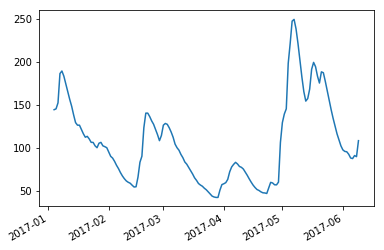

In [147]:
time_plot_una_estacion(11335002,'caudal',fecha_min='2017-01-04',fecha_max='2017-06-09')

b. Ahora escribir una función que haga plots de varias columnas, para poder visualizar caudal, precipitación y temperatura al mismo tiempo. Como las series están en diferentes escalas, sugerimos normalizarlas antes de hacer el plot (por ejemplo, dividiendo por la primera observación de cada seria)


In [148]:
def time_plot_estacion_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    dataplot = data[(data.codigo_estacion==codigo_estacion)]
    dataplot = dataplot[fecha_min:fecha_max]
    fig, ax = plt.subplots()
    for item in columnas:
        columna_ordenada = dataplot[item].sort_index()
        columna_ordenada = (columna_ordenada-columna_ordenada.mean())/columna_ordenada.std()
        ax.plot(columna_ordenada)
        fig.autofmt_xdate()
    plt.legend()
    plt.title('Estacion [%r] Normalización estándar' % codigo_estacion)

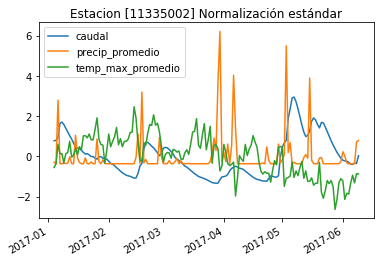

In [149]:
time_plot_estacion_varias_columnas(11335002,['caudal','precip_promedio','temp_max_promedio'],fecha_min='2017-01-04',fecha_max='2017-06-09')

4. Crea tres variables llamadas.
     * caudal_extremo
     * temp_extremo
     * precip_extremo

Vale 1 si está sobre el percentil 95 de su respectiva estación del año. 
Vale 0 en caso contrario.

* Verano ->  12-21 al 03-20 (21 de diciembre al 20 de marzo)
* Otoño ->  03-20 al 06-21 (20 de marzo al 21 de junio)
* Invierno -> 06-21 al 09-21 (21 de junio al 21 de septiembre)
* Primavera -> 09-21 al 12-21 (21 de septiembre al 21 de diciembre)

In [150]:
#Se crean dummies para cada estacion del año
data['verano'] = (data.index.month.isin([1,2]) | ((data.index.month==12) & (data.index.day>=21)) | ((data.index.month==3) & (data.index.day<=20)))*1
data['otono']= (data.index.month.isin([4,5]) | ((data.index.month==3) & (data.index.day>=20)) | ((data.index.month==6) & (data.index.day<=21)))*1
data['invierno']= (data.index.month.isin([7,8]) | ((data.index.month==6) & (data.index.day>=21)) | ((data.index.month==9) & (data.index.day<=21)))*1
data['primavera']= (data.index.month.isin([10,11]) | ((data.index.month==9) & (data.index.day>=21)) | ((data.index.month==12) & (data.index.day<=21)))*1

In [178]:
# separación de datos por estación
data_verano= data[data.index.month.isin([1,2]) | ((data.index.month==12) & (data.index.day>=21)) | ((data.index.month==3) & (data.index.day<=20))]
data_otono= data[data.index.month.isin([4,5]) | ((data.index.month==3) & (data.index.day>=20)) | ((data.index.month==6) & (data.index.day<=21))]
data_invierno= data[data.index.month.isin([7,8]) | ((data.index.month==6) & (data.index.day>=21)) | ((data.index.month==9) & (data.index.day<=21))]
data_primavera= data[data.index.month.isin([10,11]) | ((data.index.month==9) & (data.index.day>=21)) | ((data.index.month==12) & (data.index.day<=21))]

* Se inicializan las variables/columnas con 0's
* Para obtener los percentiles se crean datasets separados para cada estación del año (Idealmente se debería trabajar con el mismo dataset por memoria)
* Luego, se toman los **indices** por estación para caudal sobre el percentil 95 y se asignan 1's
* Se repite para temp_max_promedio y precip_promedio

In [151]:
# Alternativa 1
#Definicion de evento extremo: Percentil 95 de cada estacion de medición en cada estacion del año

season = ['verano','otono','invierno','primavera']
for item in data.codigo_estacion.unique():
    for estacion in season:
        perc_caud = data[(data[estacion]==1) & (data['codigo_estacion']==item)].caudal.quantile(0.95)
        perc_temp = data[(data[estacion]==1) & (data['codigo_estacion']==item)].temp_max_promedio.quantile(0.95)
        perc_precip = data[(data[estacion]==1) & (data['codigo_estacion']==item)].precip_promedio.quantile(0.95)
        data['caudal_extremo']=(data[(data[estacion]==1) & (data['codigo_estacion']==item)].caudal>=perc_caud)*1
        data['temp_extremo']=(data[(data[estacion]==1) & (data['codigo_estacion']==item)].temp_max_promedio>=perc_temp)*1
        data['precip_extremo']=(data[(data[estacion]==1) & (data['codigo_estacion']==item)].precip_promedio>=perc_precip)*1
data['caudal_extremo']=data['caudal_extremo'].fillna(value=0)
data['temp_extremo']=data['temp_extremo'].fillna(value=0)   
data['precip_extremo']=data['precip_extremo'].fillna(value=0)   

In [181]:
# Alternativa 2

#Definicion de evento extremo: Percentil 95 de cada estacion del año

perc_caudal_v=data_verano.caudal.quantile(0.95)
perc_temp_v=data_verano.temp_max_promedio.quantile(0.95)
perc_precip_v=data_verano.precip_promedio.quantile(0.95)

data.loc[data.verano==1,'caudal_extremo']=(data_verano.caudal>=perc_caudal_v)*1
data.loc[data.verano==1,'temp_extremo']=(data_verano.temp_max_promedio>=perc_temp_v)*1
data.loc[data.verano==1,'precip_extremo']=(data_verano.precip_promedio>=perc_precip_v)*1

perc_caudal_i=data_invierno.caudal.quantile(0.95)
perc_temp_i=data_invierno.temp_max_promedio.quantile(0.95)
perc_precip_i=data_invierno.precip_promedio.quantile(0.95)

data.loc[data.invierno==1,'caudal_extremo']=(data_invierno.caudal>=perc_caudal_i)*1
data.loc[data.invierno==1,'temp_extremo']=(data_invierno.temp_max_promedio>=perc_temp_i)*1
data.loc[data.invierno==1,'precip_extremo']=(data_invierno.precip_promedio>=perc_precip_i)*1

perc_caudal_o=data_otono.caudal.quantile(0.95)
perc_temp_o=data_otono.temp_max_promedio.quantile(0.95)
perc_precip_o=data_otono.precip_promedio.quantile(0.95)

data.loc[data.otono==1,'caudal_extremo']=(data_otono.caudal>=perc_caudal_o)*1
data.loc[data.otono==1,'temp_extremo']=(data_otono.temp_max_promedio>=perc_temp_o)*1
data.loc[data.otono==1,'precip_extremo']=(data_otono.precip_promedio>=perc_precip_o)*1

perc_caudal_p=data_primavera.caudal.quantile(0.95)
perc_temp_p=data_primavera.temp_max_promedio.quantile(0.95)
perc_precip_p=data_primavera.precip_promedio.quantile(0.95)

data.loc[data.primavera==1,'caudal_extremo']=(data_primavera.caudal>=perc_caudal_p)*1
data.loc[data.primavera==1,'temp_extremo']=(data_primavera.temp_max_promedio>=perc_temp_p)*1
data.loc[data.primavera==1,'precip_extremo']=(data_primavera.precip_promedio>=perc_precip_p)*1


* Responder preguntas ¿Les parece razonable esta medida para capturar algo “extremo”? ¿Usarían otra? ¿Cuál? (no codifiquen)
* Me parece una buena idea. Otra alternativa, puede ser definir valores de corte para cada estación del año, sin considerar estaciones de medicion. Para definir los valores de corte se podría tomar el promedio de los percentil 95 de cada estación dada una ventana de tiempo. Por ejemplo, agrupar cada 5 años y sacar el promedio de los percentiles 95 de invierno. Luego ese sería el corte. La idea general consiste en definir valores extremos dada una ventana de tiempo, es como una extensión de la propuesta de Spike.
* Una vez creadas las variables se nos pide analizar la variable caudal extremo y ver con cuencas


5. Analicen la variable caudal_extremo. Los comportamientos en diferentes cuencas son muy diferentes?

Para poder determinar si las distintas cuencas presentan un comportamiento similar es necesario utilizar métricas que puedan reflejarlo. Variables que pueden caracterizar la distribución:

* cantidad de valores extremos o cantidad de valores no extremos
* porcentaje de valores extremos
* promedio y desviación estándar


### Gráfico 'Caudales extremos por cuenca'

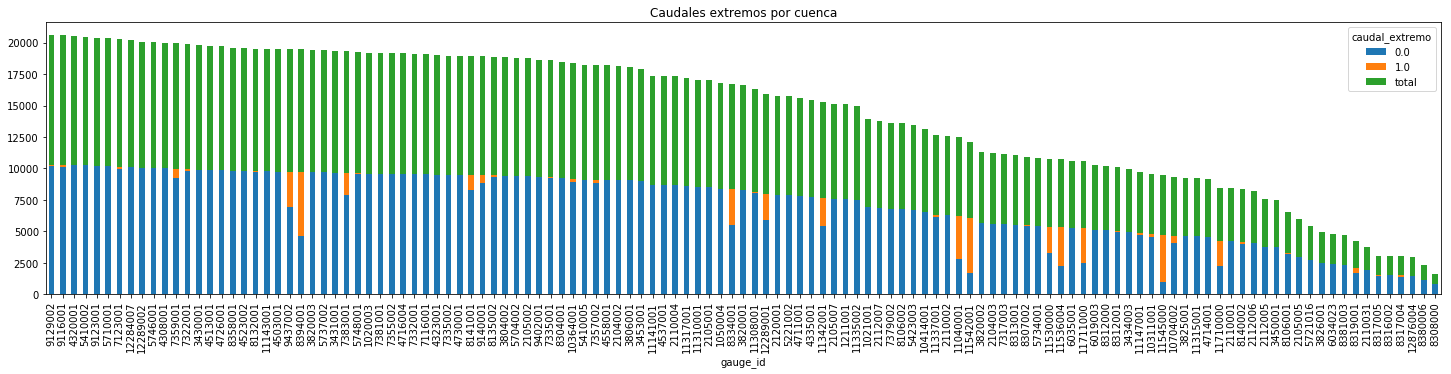

In [183]:
tabla_total = pd.crosstab(index=data.gauge_id,columns=data.caudal_extremo)
tabla_total['total']=tabla_total[0]+tabla_total[1]
tabla_total.sort_values('total', ascending=False).plot(kind="bar", figsize=(25,5),stacked=True)
plt.title('Caudales extremos por cuenca')
plt.show()

Del gráfico anterior se puede notar que las distintas cuencas poseen muestras de distintos tamaños.

6. Hagan un plot del porcentaje de eventos extremos a través del tiempo (caudal_extremo, temp_extremo, precip_extremo). Se han vuelto más o menos comunes?

Se requiere definir un total, es decir una ventana de tiempo, para obtener un porcentaje sobre eventos totales. Si se toman años, en su agregacion de meses se pierde una posible estacionalidad. Primero se grafican por año, luego por estación del año (x4 datos).

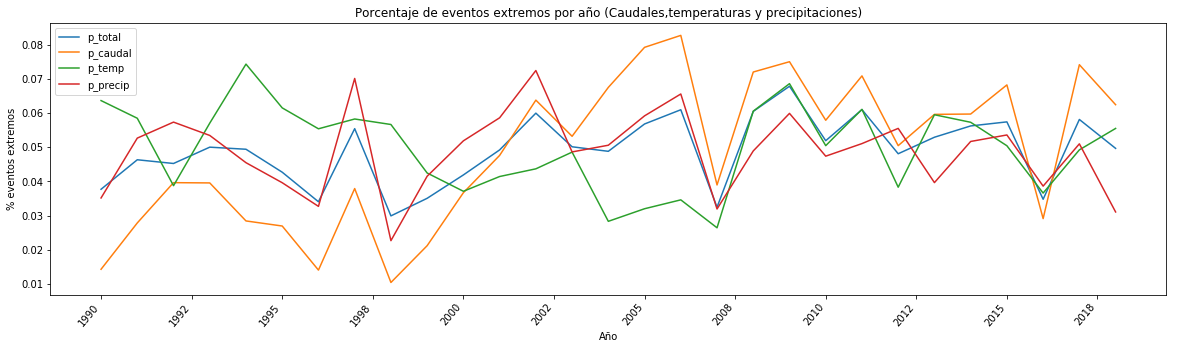

In [184]:
from statistics import mean 
from matplotlib.ticker import MaxNLocator
datafra=pd.DataFrame(columns=['year','p_total','p_caudal','p_temp','p_precip'])
for item in data.index.year.unique():
    porcentaje_caudal = data[str(item)].caudal_extremo.mean()
    porcentaje_temp = data[str(item)].temp_extremo.mean()
    porcentaje_precip = data[str(item)].precip_extremo.mean()
    porcentaje_total = mean((porcentaje_caudal,porcentaje_temp,porcentaje_precip))
    datafra = datafra.append({'year':str(item),'p_total': porcentaje_total,'p_caudal':porcentaje_caudal,'p_temp':porcentaje_temp,'p_precip':porcentaje_precip},ignore_index=True)
datafra=datafra.sort_values('year')    
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(datafra.year,datafra.p_total)
plt.plot(datafra.year,datafra.p_caudal)
plt.plot(datafra.year,datafra.p_temp)
plt.plot(datafra.year,datafra.p_precip)
plt.legend()
locator = MaxNLocator(nbins=15)
ax.xaxis.set_major_locator(locator)
plt.xlabel('Año')
plt.ylabel('% eventos extremos')
plt.xticks(rotation=50, ha="right")
plt.title('Porcentaje de eventos extremos por año (Caudales,temperaturas y precipitaciones)')
plt.show()


Del gráfico anterior se puede notar que existe una tendencia al aumento del porcentaje de eventos extremos. Sin embargo, se pierde información al estar agrupada anualmente. A continuación se verá si existe estacionalidad, es decir, revisaremos el comportamiento agrupando por mes.

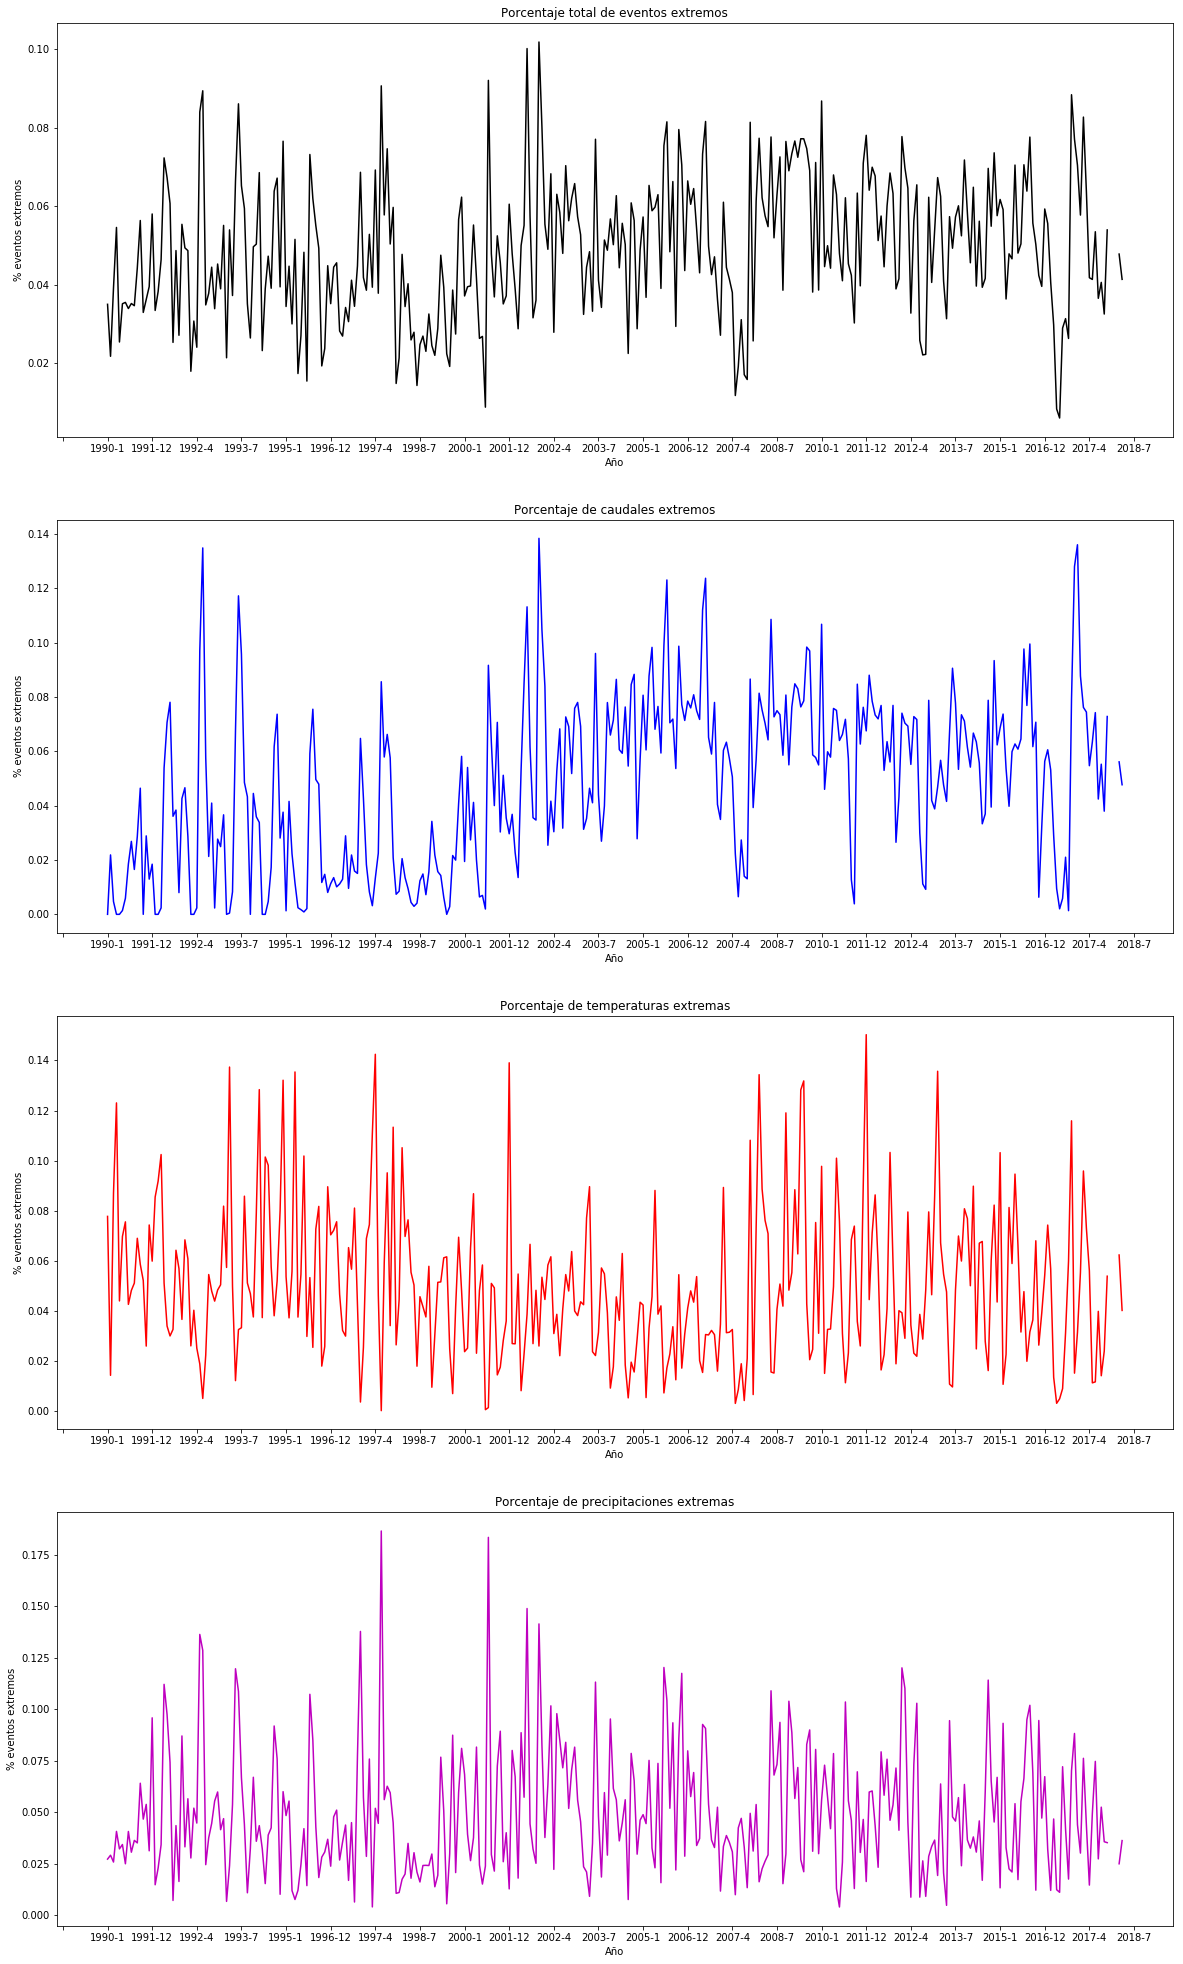

In [185]:
 datafra=pd.DataFrame(columns=['date','p_total','p_caudal','p_temp','p_precip'])
for item in data.index.year.unique():
    for month in data.index.month.unique():
        porcentaje_caudal = data[str(item)+'-'+str(month)].caudal_extremo.mean()
        porcentaje_temp = data[str(item)+'-'+str(month)].temp_extremo.mean()
        porcentaje_precip = data[str(item)+'-'+str(month)].precip_extremo.mean()
        porcentaje_total = mean((porcentaje_caudal,porcentaje_temp,porcentaje_precip))
        datafra = datafra.append({'date':str(item)+'-'+str(month),'p_total': porcentaje_total,'p_caudal':porcentaje_caudal,'p_temp':porcentaje_temp,'p_precip':porcentaje_precip},ignore_index=True)
datafra=datafra.sort_values('date')    
fig, axs = plt.subplots(4,1, figsize=(20,35))
axs[0].plot(datafra.date,datafra.p_total, color='k')
axs[0].set_title('Porcentaje total de eventos extremos')
axs[1].plot(datafra.date,datafra.p_caudal, color= 'b')
axs[1].set_title('Porcentaje de caudales extremos')
axs[2].plot(datafra.date,datafra.p_temp, color='r')
axs[2].set_title('Porcentaje de temperaturas extremas')
axs[3].plot(datafra.date,datafra.p_precip, color='m')
axs[3].set_title('Porcentaje de precipitaciones extremas')
locator = MaxNLocator(nbins=30)
for item in axs:
    item.xaxis.set_major_locator(locator)
    item.set_xlabel('Año')
    item.set_ylabel('% eventos extremos')
#plt.xticks(rotation=50, ha="right")
plt.show()

De los gráficos anteriores se puede notar que existen distintos puntos altos y bajos que pareciera que se repiten cada cierto mes en particular. Para ver mejor este posible comportamiento, reduciremos los puntos ploteados.

In [159]:
datafra['date']=pd.to_datetime(datafra['date'])
datafra=datafra.set_index('date')

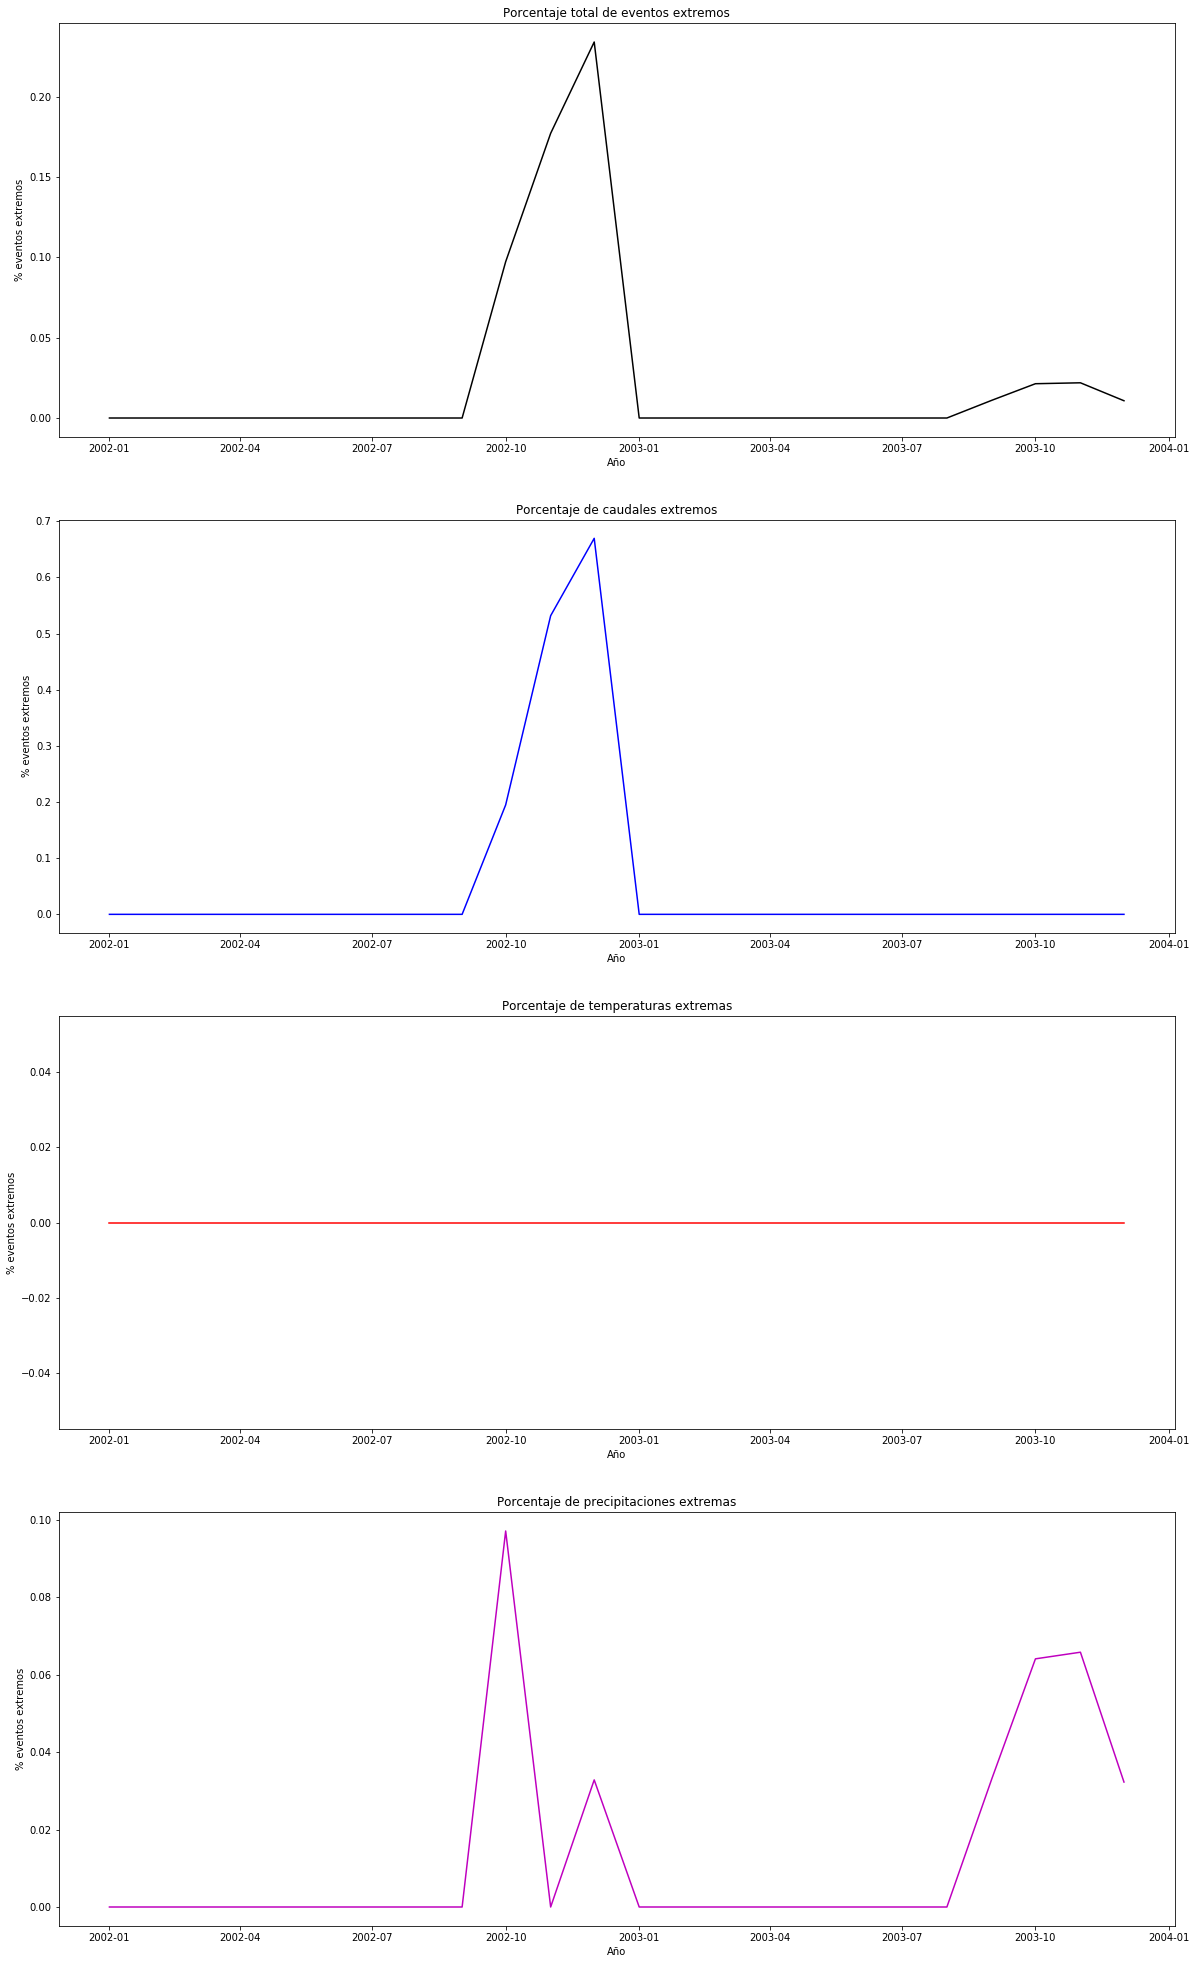

In [160]:
datafra=datafra.sort_values(by='date')
d=datafra['2002':'2003']
fig, axs = plt.subplots(4,1, figsize=(20,35))
axs[0].plot(d.index,d.p_total, color='k')
axs[0].set_title('Porcentaje total de eventos extremos')
axs[1].plot(d.index,d.p_caudal, color= 'b')
axs[1].set_title('Porcentaje de caudales extremos')
axs[2].plot(d.index,d.p_temp, color='r')
axs[2].set_title('Porcentaje de temperaturas extremas')
axs[3].plot(d.index,d.p_precip, color='m')
axs[3].set_title('Porcentaje de precipitaciones extremas')
for item in axs:
    item.set_xlabel('Año')
    item.set_ylabel('% eventos extremos')
plt.show()

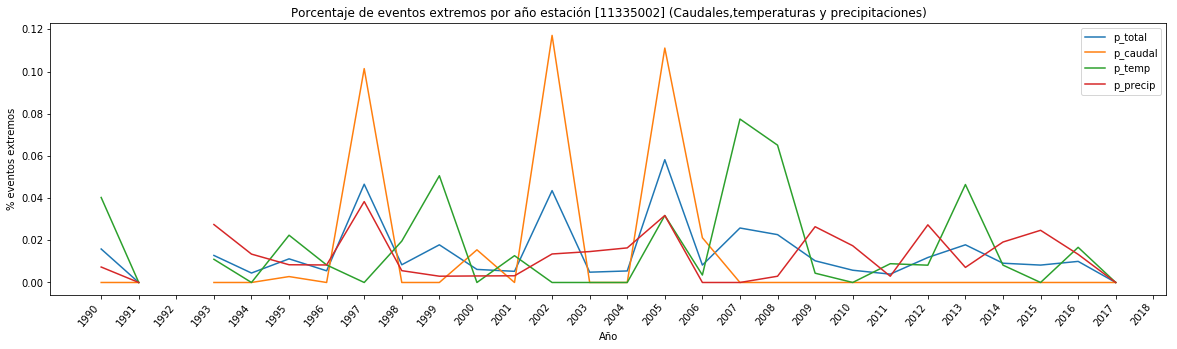

In [161]:
def porcentaje_eventos_extremos_estacion(codigo_estacion):
    datafra=pd.DataFrame(columns=['year','p_total','p_caudal','p_temp','p_precip'])
    for item in data.index.year.unique():
        porcentaje_caudal = data[data.codigo_estacion==codigo_estacion][str(item)].caudal_extremo.mean()
        porcentaje_temp = data[data.codigo_estacion==codigo_estacion][str(item)].temp_extremo.mean()
        porcentaje_precip = data[data.codigo_estacion==codigo_estacion][str(item)].precip_extremo.mean()
        porcentaje_total = mean((porcentaje_caudal,porcentaje_temp,porcentaje_precip))
        datafra = datafra.append({'year':str(item),'p_total': porcentaje_total,'p_caudal':porcentaje_caudal,'p_temp':porcentaje_temp,'p_precip':porcentaje_precip},ignore_index=True)
    datafra=datafra.sort_values('year')    
    plt.figure(figsize=(20,5))
    plt.plot(datafra.year,datafra.p_total)
    plt.plot(datafra.year,datafra.p_caudal)
    plt.plot(datafra.year,datafra.p_temp)
    plt.plot(datafra.year,datafra.p_precip)
    plt.legend()
    plt.xlabel('Año')
    plt.ylabel('% eventos extremos')
    plt.xticks(rotation=50, ha="right")
    plt.title('Porcentaje de eventos extremos por año estación [%r] (Caudales,temperaturas y precipitaciones)' % codigo_estacion)
    plt.show()
porcentaje_eventos_extremos_estacion(11335002)    

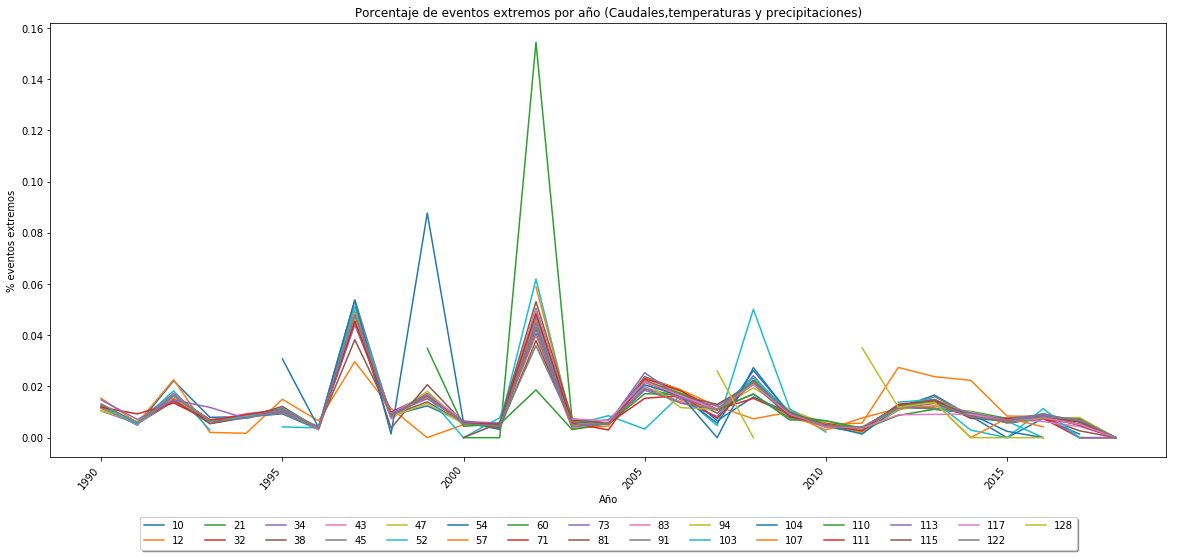

In [162]:
#eventos extremos totales por cuenca por año
# **Advertencia** : Demora un poco este codigo
from statistics import mean 
import numpy as np
fig, ax= plt.subplots(figsize=(20,8))
for cuenca in np.sort(data.codigo_cuenca.unique()):
    datafra=pd.DataFrame(columns=['year'],data=data.index.year.unique().values)
    datafra[cuenca]=None
    for item in data[data.codigo_cuenca==cuenca].index.year.unique().sort_values():
        porcentaje_caudal = data[data.codigo_cuenca==cuenca][str(item)].caudal_extremo.mean()
        porcentaje_temp = data[data.codigo_cuenca==cuenca][str(item)].temp_extremo.mean()
        porcentaje_precip = data[data.codigo_cuenca==cuenca][str(item)].precip_extremo.mean()
        porcentaje_total = mean((porcentaje_caudal,porcentaje_temp,porcentaje_precip))
        datafra.loc[datafra.year==item,cuenca]=porcentaje_total
    datafra=datafra.sort_values('year', ascending=True)
    plt.plot(datafra.year,datafra[cuenca])    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fancybox=True, shadow=True, ncol=15)
plt.xlabel('Año')
plt.ylabel('% eventos extremos')
plt.xticks(rotation=50, ha="right")
plt.title('Porcentaje de eventos extremos por año (Caudales,temperaturas y precipitaciones)')
plt.show()



7. Predicción de caudal extremo. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de un caudal extremo (la variable binaria caudal_extremo). Siéntete libre de generar variables adicionales y/o complementar con variables externas. ¿Qué datos podemos usar y cuáles no? Por supuesto, no podemos usar datos del futuro, pero ¿es lícito usar información del mismo día? ¿del día anterior? Todo depende de cómo propongas que el modelo se puede usar. Haz una propuesta de cómo usar tu modelo en la práctica (por ejemplo: una vez entrenado, voy a tomar los datos de XXX hasta el lunes y predecir para el día siguiente). Dada la propuesta, declara restricciones de información para caudal, temperatura y precipitación


Para la predicción de caudales extremos se deben definir variables y ventana de tiempo.

In [ ]:
y_train = train.caudal_extremo
x_train = train[[]]

y_test = test.caudal_extremo
x_test = test[[]]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression()
model.fit(x_train,y_train)
prediction=model.predict(x_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,y_test))

8 Análisis de resultado del modelo.

* Qué performance tiene el modelo? Qué métricas usaste para medir esa performance? Cuáles son las variables más importantes? Qué opinión te merecen los resultados?

* Si quisiéramos capturar alrededor de un 70% de los eventos de caudales extremos. Cuál es la precisión de tu modelo con ese porcentaje de captura? Cuéntanos si te parece útil.
